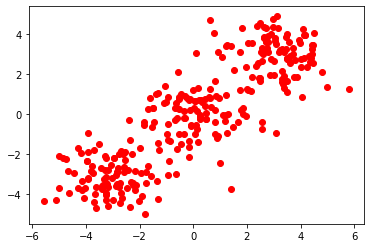

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn import metrics
import random
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from matplotlib.pyplot import figure
from sklearn.cluster import KMeans

n_clusters = 3
k1 = 32
k2 = 48

center = 3
dev = 1
n_points = 100
cluster = [None]*6

cluster[0] = np.random.normal(0, dev, (n_points,2))
cluster[1] = np.random.normal(center, dev, (n_points,2))
cluster[2] = np.random.normal(-center, dev, (n_points,2))
cluster[3] = np.concatenate((np.random.normal(-center, dev, (n_points,1)),np.random.normal(center, dev, (n_points,1))), axis=1)
cluster[4] = np.concatenate((np.random.normal(-2*center, dev, (n_points,1)),np.random.normal(0, dev, (n_points,1))), axis=1)
cluster[5] = np.concatenate((np.random.normal(center, dev, (n_points,1)),np.random.normal(-center, dev, (n_points,1))), axis=1)

noise1 = np.random.uniform(low=-8, high=8, size = n_clusters*n_points)
noise2 = np.random.uniform(low=-8, high=8, size = n_clusters*n_points)

X_train = cluster[0]
for i in range(1,n_clusters):
    X_train = np.concatenate((X_train,cluster[i]))

X_train = shuffle(X_train, random_state=0)

plt.scatter(X_train[:,0], X_train[:,1], c='red')

X_train = np.column_stack((X_train, noise1))
X_train = np.column_stack((X_train, noise2))

In [2]:
import torch
from torch import nn, optim
import torch.nn.functional as F

device = torch.device("cpu")

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X_train):
        X = torch.from_numpy(X_train).float()
        X.requires_grad=True
        self.X = X.to(device)


    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index]
    
train_data = CustomDataset(X_train)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=10*n_clusters)

class Net(nn.Module):

    def __init__(self, n_features):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_features, k1, bias=True)
        self.fc2 = nn.Linear(k1, k2, bias=True)
        self.fc3 = nn.Linear(k2, k1, bias=True)
        self.fc4 = nn.Linear(k1, n_clusters, bias=True)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.relu(self.fc3(x))
        return F.softmin(self.fc4(x))

net = Net(4)

net = net.to(device)

In [3]:
def silhouette(X, y):
    distances = torch.cdist(X, X, p=0.1)
    weighted_distances = torch.matmul(distances, y)
    sum_p = torch.sum(y, dim = 0)
    sum_p_mat = torch.empty(y.shape[0], y.shape[1])
    for i in range(y.shape[0]):
        sum_p_mat[i] = sum_p - y[i]
    alphas = torch.div(weighted_distances, sum_p)
    betas = torch.empty(alphas.shape[0], alphas.shape[1])
    betas = betas.to(device)
    for i in range(alphas.shape[0]):
        for j in range(alphas.shape[1]):
            betas[i][j] = min([alphas[i][x] for x in range(alphas.shape[1]) if x!=j])
    max_ab = torch.max(alphas, betas)
    s = betas - alphas
    s = torch.div(s, max_ab)
    s = s*y
    s = torch.sum(s, dim=1)
    s = torch.mean(s)
    return s

In [4]:
y_true = []
X_simple = np.delete(X_train, 2, 1)
X_simple = np.delete(X_simple, 2, 1)
for x in X_simple:
    for i in range(len(cluster)):
        if len(np.where(cluster[i] == x)[0])>0:
            y_true.append(i)

In [5]:
true = np.zeros((len(X_train), n_clusters))
for i in range(len(X_train)):
    true[i][y_true[i]] = 1

print(silhouette(torch.from_numpy(X_train).float(), torch.from_numpy(true).float()))


tensor(0.3895)


In [12]:
optimizer = optim.Adam(net.parameters(), lr=0.01)
train_data = CustomDataset(X_train)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=int(n_points*n_clusters/1))

for epoch in range(80):
    for n, X in enumerate(train_loader):
        y = net(X)
        y = torch.squeeze(y)
        s = silhouette(X, y)
        s = (1 - s)

        loss = s 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(epoch)
    print(1 - s)

<ipython-input-2-8116946491fd>:36: UserWarning: Implicit dimension choice for softmin has been deprecated. Change the call to include dim=X as an argument.
  return F.softmin(self.fc4(x))


0
tensor(0.3831, grad_fn=<RsubBackward1>)
1
tensor(0.3828, grad_fn=<RsubBackward1>)
2
tensor(0.3831, grad_fn=<RsubBackward1>)
3
tensor(0.3811, grad_fn=<RsubBackward1>)
4
tensor(0.3815, grad_fn=<RsubBackward1>)
5
tensor(0.3837, grad_fn=<RsubBackward1>)
6
tensor(0.3863, grad_fn=<RsubBackward1>)
7
tensor(0.3878, grad_fn=<RsubBackward1>)
8
tensor(0.3890, grad_fn=<RsubBackward1>)
9
tensor(0.3890, grad_fn=<RsubBackward1>)
10
tensor(0.3908, grad_fn=<RsubBackward1>)
11
tensor(0.3938, grad_fn=<RsubBackward1>)
12
tensor(0.3938, grad_fn=<RsubBackward1>)
13
tensor(0.3902, grad_fn=<RsubBackward1>)
14
tensor(0.3912, grad_fn=<RsubBackward1>)
15
tensor(0.3916, grad_fn=<RsubBackward1>)
16
tensor(0.3893, grad_fn=<RsubBackward1>)
17
tensor(0.3892, grad_fn=<RsubBackward1>)
18
tensor(0.3846, grad_fn=<RsubBackward1>)
19
tensor(0.3892, grad_fn=<RsubBackward1>)
20
tensor(0.3893, grad_fn=<RsubBackward1>)
21
tensor(0.3893, grad_fn=<RsubBackward1>)
22
tensor(0.3924, grad_fn=<RsubBackward1>)
23
tensor(0.3955, gra

In [7]:
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

<ipython-input-2-8116946491fd>:36: UserWarning: Implicit dimension choice for softmin has been deprecated. Change the call to include dim=X as an argument.
  return F.softmin(self.fc4(x))


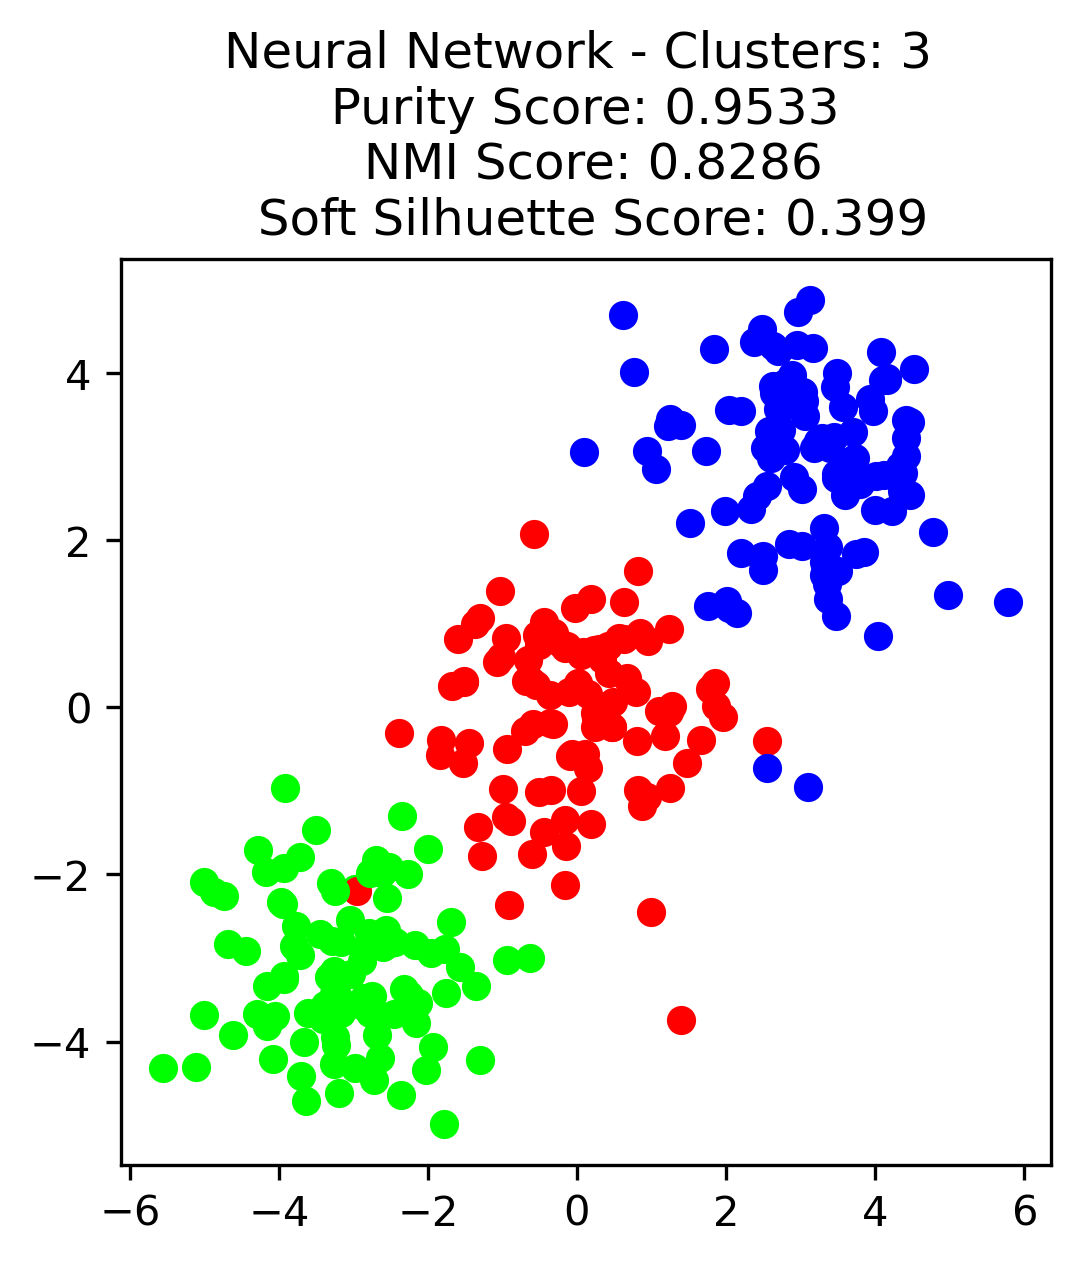

In [13]:
X = torch.from_numpy(X_train).float()
X.requires_grad=True
y = net(X)
s = silhouette(X, y)
y = y.detach().numpy()
X = X.detach().numpy()

color1 = (0, 0, 1)
color2 = (0, 1, 0)
color3 = (1, 0 , 0)
color4 = (0, 1 , 1)
color5 = (1, 1, 0)
color6 = (1, 0, 1)
colors = [color1, color2, color3, color4, color5, color6, color1, color2, color3, color4, color5, color6]

figure(figsize=(4, 4), dpi=300)
for i in range(y.shape[0]):
    color = [0, 0, 0]
    for j in range(y.shape[1]):
        color[0] = min(round(color[0] + y[i][j]*colors[j][0], 3), 1)
        color[1] = min(round(color[1] + y[i][j]*colors[j][1], 3), 1)
        color[2] = min(round(color[2] + y[i][j]*colors[j][2], 3), 1)
    color = tuple(color)
    plt.scatter(X[i,0], X[i,1], color=color)
plt.title(f'Neural Network - Clusters: {n_clusters} \n Purity Score: {purity_score(y_true, np.argmax(y, axis=-1)):.4f} \n NMI Score: {normalized_mutual_info_score(y_true, np.argmax(y, axis=-1)):.4f}\n Soft Silhuette Score: {s:.3f}')
plt.show()

In [9]:
X = torch.from_numpy(X_train).float()
X.requires_grad=True

gm = GaussianMixture(n_components=n_clusters, random_state=0).fit(X_train)
probabilities = gm.predict_proba(X_train)
s = silhouette(X, torch.from_numpy(probabilities).float())
print(f'Mixture Model - Clusters: {n_clusters} \n Purity Score: {purity_score(y_true, np.argmax(probabilities, axis=-1))} \n Soft Silhouette Score: {s} \n NMI Score: {normalized_mutual_info_score(y_true, np.argmax(probabilities, axis=-1))}')


Mixture Model - Clusters: 3 
 Purity Score: 0.38333333333333336 
 Soft Silhouette Score: 0.2074916660785675 
 NMI Score: 0.007405458354340274


In [10]:
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X_train)
print(f'Mixture Model - Clusters: {n_clusters} \n Purity Score: {purity_score(y_true, kmeans.labels_)}')


Mixture Model - Clusters: 3 
 Purity Score: 0.38
